# Modelo de tarifación Airbnb en New York

Iteración previa Nov 3, 2020

Modificado Junio 16, 2021

* [Lectura de Datos](#Lectura-de-Datos)
* [Split: Training & Testing](#Split:-Training-&-Testing)
* [Escalando los datos](#Escalando-los-datos)
* [Separando caracteristicas y etiquetas](#Separando-caracteristicas-y-etiquetas)
* [El modelo](#El-modelo)
    * [Arquitectura](#Arquitectura)
    * [Entrenamiento](#Entrenamiento)
    * [Predicciones](#Predicciones)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, optimizers, regularizers
from numpy.random import seed
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


seed(123)
print(tf.__version__)

2.4.0


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows= None

## Lectura de Datos

In [3]:
dataset=pd.read_csv('Listings_clean.csv')

In [4]:
dataset=dataset.dropna()
print('El dataset de entrada contiene', len(dataset.columns), 'columnas', 'y', len(dataset), 'filas')

El dataset de entrada contiene 39 columnas y 35300 filas


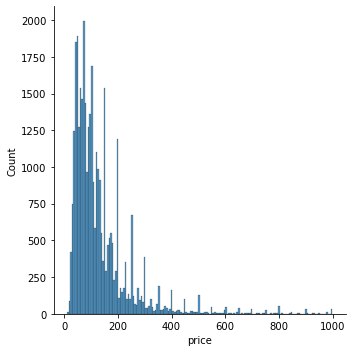

In [5]:
_=sns.displot(dataset['price'])


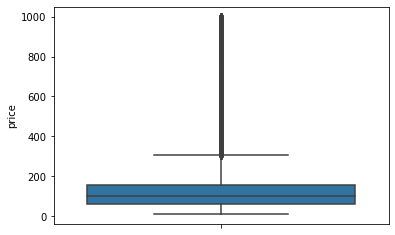

In [6]:
_=sns.boxplot(y=dataset['price'])

In [7]:
dataset['price'].describe()

count    35300.000000
mean       131.916289
std        115.642213
min         10.000000
25%         61.000000
50%        100.000000
75%        159.000000
max        999.000000
Name: price, dtype: float64

In [8]:
dataset['price'].quantile([0.1,0.5,0.8,0.85,0.9])

0.10     43.0
0.50    100.0
0.80    180.0
0.85    200.0
0.90    250.0
Name: price, dtype: float64

In [9]:
dataset=dataset[(dataset['price']>0)&(dataset['price']<248)]
dataset['price'].describe()

count    31484.000000
mean       101.076706
std         52.295245
min         10.000000
25%         59.000000
50%         90.000000
75%        135.000000
max        247.000000
Name: price, dtype: float64

In [10]:
dataset.shape

(31484, 39)

In [11]:
dataset=dataset.drop(columns=['Unnamed: 0', 'id'])

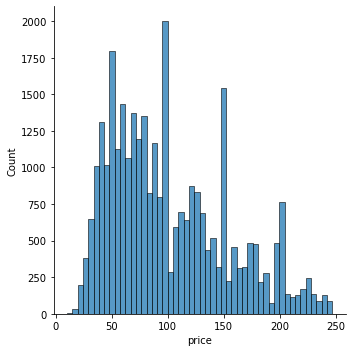

In [12]:
sns.displot(dataset['price'])
plt.show()

In [13]:
from sklearn.preprocessing import quantile_transform

In [14]:
dataset['price']=quantile_transform(dataset['price'].to_frame(),
                                    n_quantiles=900,
                                    output_distribution='normal',
                                    random_state=0)

In [15]:
len(dataset[dataset['price']>4])

10

In [16]:
dataset=dataset[(dataset['price']<4)& (dataset['price']>-4)]

In [17]:
dataset.price.describe()

count    31468.000000
mean        -0.000413
std          0.996258
min         -3.373732
25%         -0.684147
50%         -0.011153
75%          0.670121
max          3.260452
Name: price, dtype: float64

## Split: Training & Testing

In [18]:
from sklearn.model_selection import train_test_split

target=dataset.pop('price')
data_train, data_test, target_train, target_test=train_test_split(dataset, 
                                                                  target, 
                                                                  test_size=0.2,
                                                                  random_state=42)

In [19]:
data_train.head(3)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,instant_bookable,calculated_host_listings_count,t_bathrooms,am_wifi,am_air conditioning,am_kitchen,am_parking,am_patio,am_barbecue,am_outdoor,am_games,am_soap,am_shampoo,apartment,house,other,room,entire home/apt,private room,shared room,private,shared
6162,0.0,1.0,1.0,1.0,40.68316,-73.92761,2,1.0,1.0,30,1125,1,0,2,0,1,1.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4699,0.0,1.0,1.0,1.0,40.71060,-74.01496,2,1.0,1.0,30,1125,1,0,3,0,1,1.0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
28763,0.0,0.0,1.0,0.0,40.80369,-73.95180,6,2.0,2.0,30,1125,1,1,3,0,2,1.0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [20]:
target_train.head(3)

6162    -1.136279
4699     2.089003
28763    0.061380
Name: price, dtype: float64

## Escalando los datos

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [22]:
scaler=make_pipeline(StandardScaler())

In [23]:
scaler.fit(data_train)

Pipeline(steps=[('standardscaler', StandardScaler())])

In [24]:
normed_train_data=scaler.transform(data_train)
normed_test_data=scaler.transform(data_test)

In [25]:
len(normed_train_data[0])

36

# El modelo

### Arquitectura

In [26]:
# ,kernel_regularizer=regularizers.l2(0.05)
# La mejor que llevo es 512, 256, 32, dropout 0.1 y sin regularizador
def build_model():  
  model = keras.Sequential([
    layers.Dense(1024, activation='relu',input_shape=[len(normed_train_data[0])]),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(lr=0.00001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [27]:
model = build_model()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              37888     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,358,145
Trainable params: 1,358,145
Non-trainable params: 0
______________________________________________

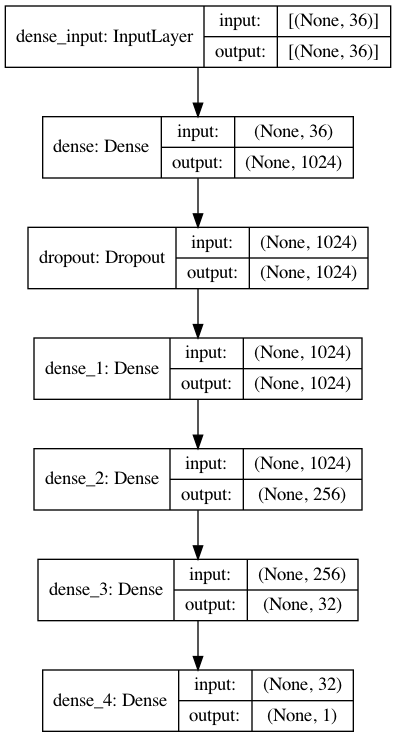

In [29]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [30]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.16744618],
       [-0.03702181],
       [-0.11716355],
       [-0.10375828],
       [-0.02495955],
       [-0.0478121 ],
       [ 0.00413185],
       [ 0.00301268],
       [-0.09039418],
       [ 0.14737828]], dtype=float32)

### Entrenamiento

In [31]:
# Display training progress by printing a single dot for each completed epoch
time_start = time.time()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 150

history = model.fit(
  normed_train_data, target_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

time_end = time.time()
print(f"\nTiempo de ejecución: {round((time_end - time_start)/60,1)} minutos")


....................................................................................................
..................................................
Tiempo de ejecución: 19.0 minutos


In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
145,0.292728,0.413703,0.292728,0.370772,0.463363,0.370772,145
146,0.294819,0.416241,0.294819,0.370019,0.462873,0.370019,146
147,0.294150,0.416020,0.294150,0.369951,0.464248,0.369951,147
148,0.293896,0.415154,0.293896,0.371226,0.463037,0.371226,148
149,0.292985,0.414319,0.292985,0.370339,0.463727,0.370339,149


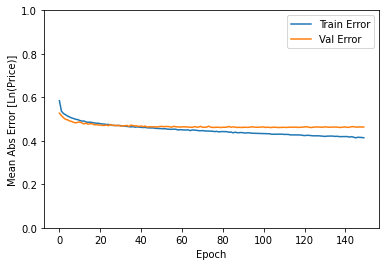

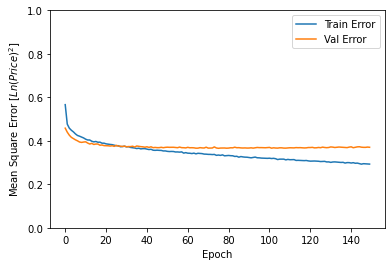

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Ln(Price)]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Ln(Price)^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0.0,1])
  plt.legend()
  plt.show()


plot_history(history)

In [34]:
loss, mae, mse = model.evaluate(normed_test_data, target_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

197/197 - 1s - loss: 2.3956 - mae: 0.4858 - mse: 2.3956
Testing set Mean Abs Error:  0.49


## Predicciones

6294


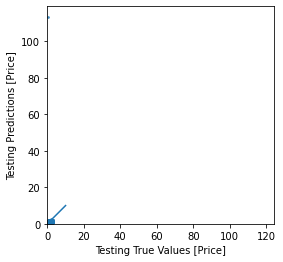

In [35]:
test_predictions = model.predict(normed_test_data).flatten()
print(len(test_predictions))
plt.scatter(target_test, test_predictions,alpha=0.7,s=3)
plt.xlabel('Testing True Values [Price]')
plt.ylabel('Testing Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10, 10], [-10, 10]) 

In [36]:
test_pre=pd.DataFrame(test_predictions, columns=['test_prediction'])
test_pre.sort_values(by='test_prediction', ascending=False).head() ##ojo con el 2572

,test_prediction
2572,113.367416
144,2.480085
129,2.293297
1237,2.240090
2769,2.239630


6294


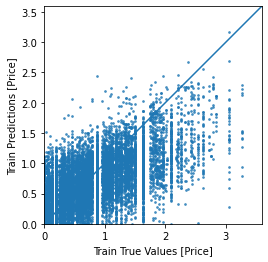

In [37]:
train_predictions = model.predict(normed_train_data).flatten()
print(len(test_predictions))
plt.scatter(target_train, train_predictions,alpha=0.7,s=3)
plt.xlabel('Train True Values [Price]')
plt.ylabel('Train Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.xlim()[1]])
_ = plt.plot([-10, 10], [-10, 10]) ##Revisar como dismunuir la varianza

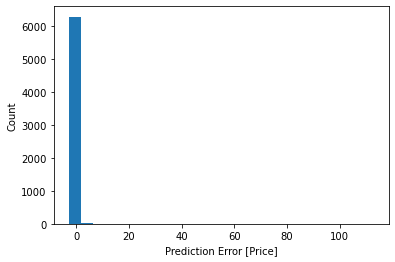

In [38]:
error = test_predictions - target_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")

In [39]:
y_test_pred = model.predict(normed_test_data)
y_train_pred = model.predict(normed_train_data)
print("Training MAE:", round(mean_squared_error(target_train, y_train_pred),4))
print("Validation MAE:", round(mean_squared_error(target_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(target_train, y_train_pred),4))
print("Validation r2:", round(r2_score(target_test, y_test_pred),4))

Training MAE: 0.2811
Validation MAE: 2.3956

Training r2: 0.7174
Validation r2: -1.4341
